In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns

#### 데이터 불러오기

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

#### train과 test 파일을 합치기

In [4]:
df_test['split'] = 'test'
df_train['split'] = 'train'
print('train shape : {}, test shape : {}'.format(df_train.shape,df_test.shape),end='\n\n')

df = pd.concat([df_test,df_train],ignore_index=True)
df

train shape : (282451, 17), test shape : (139119, 16)



,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,split,Weekly_Sales
0,28,40,2012-01-06,False,50.43,3.599,5155.86,19549.51,218.29,636.73,5218.50,130.157516,12.187,A,206302,test,NaN
1,18,93,2012-03-09,False,38.10,3.876,7410.18,368.19,25.46,1852.39,2332.07,137.506690,8.075,B,120653,test,NaN
2,38,4,2011-05-27,False,76.67,4.087,NaN,NaN,NaN,NaN,NaN,129.062355,13.736,C,39690,test,NaN
3,29,33,2010-03-12,False,43.43,2.805,NaN,NaN,NaN,NaN,NaN,131.784000,10.064,B,93638,test,NaN
4,13,52,2010-10-29,False,45.12,2.841,NaN,NaN,NaN,NaN,NaN,126.436419,7.795,A,219622,test,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,27,18,2012-10-19,False,56.53,4.153,2639.32,NaN,4.77,575.48,3147.23,142.863363,8.000,A,204184,train,20775.91
421566,39,36,2010-05-21,False,76.67,2.826,NaN,NaN,NaN,NaN,NaN,209.392294,8.464,A,184109,train,5350.00
421567,14,29,2010-04-30,False,53.15,2.921,NaN,NaN,NaN,NaN,NaN,181.662036,8.899,A,200898,train,10939.87
421568,15,90,2011-07-01,False,67.43,3.916,NaN,NaN,NaN,NaN,NaN,135.446800,7.806,B,123737,train,5013.89


#### 전처리

In [5]:
# 화씨 온도를 섭씨 온도로 변환
df['Temperature'] = (df['Temperature'] - 32) / 1.8

# 날짜 데이터 datetime형으로 변환 및 연도, 월, 일, 요일 분리
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] =df['Date'].dt.year
df['Month'] =df['Date'].dt.month
df['Week'] =df['Date'].dt.week
df['Day'] =df['Date'].dt.day
df['Day_name'] =df['Date'].dt.day_name()

# type값을 0,1,2로
ordinal_ecd = OrdinalEncoder(dtype='int64')

encoded = ordinal_ecd.fit_transform(df['Type'].to_numpy().reshape(-1,1))
df.loc[:,'Type'] = encoded
df['Type']

C:\Users\popcorn\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


0         0
1         1
2         2
3         1
4         0
         ..
421565    0
421566    0
421567    0
421568    1
421569    0
Name: Type, Length: 421570, dtype: int64

#### train과 test파일을 다시 분리

In [6]:
df_test = df[df['split'] == 'test']
df_train = df[df['split'] == 'train']

x_train = df_train.drop(['Date', 'Day_name', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','split','Weekly_Sales'], axis=1)
y_train = df_train['Weekly_Sales']

#### train set의 20%를 validation set으로 분리

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2)

==================================================================================================================  
#### XGBoost regression 모델 생성

In [7]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=70, max_depth=6)

# n_estimators : 학습횟수
# n_jobs : 병렬처리로 보통 cpu core 수로 정하는 것이 좋음
# learning_rate ; 학습률
# max_depth : 트리의 최대 깊이


#### train set으로 모델을 훈련

In [8]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=70, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### 트리를 확인
- colab에서는 정상적으로 돌아가는데 vscode에서 오류발생
- 아래의 사진과 같이 tree가 출력됨

In [13]:
# import matplotlib.pyplot as plt
# from xgboost import plot_tree
# from matplotlib.pylab import rcParams
# %matplotlib inline

# rcParams['figure.figsize'] = 30,30

In [20]:
# plot_tree(model, rankdir='LR')

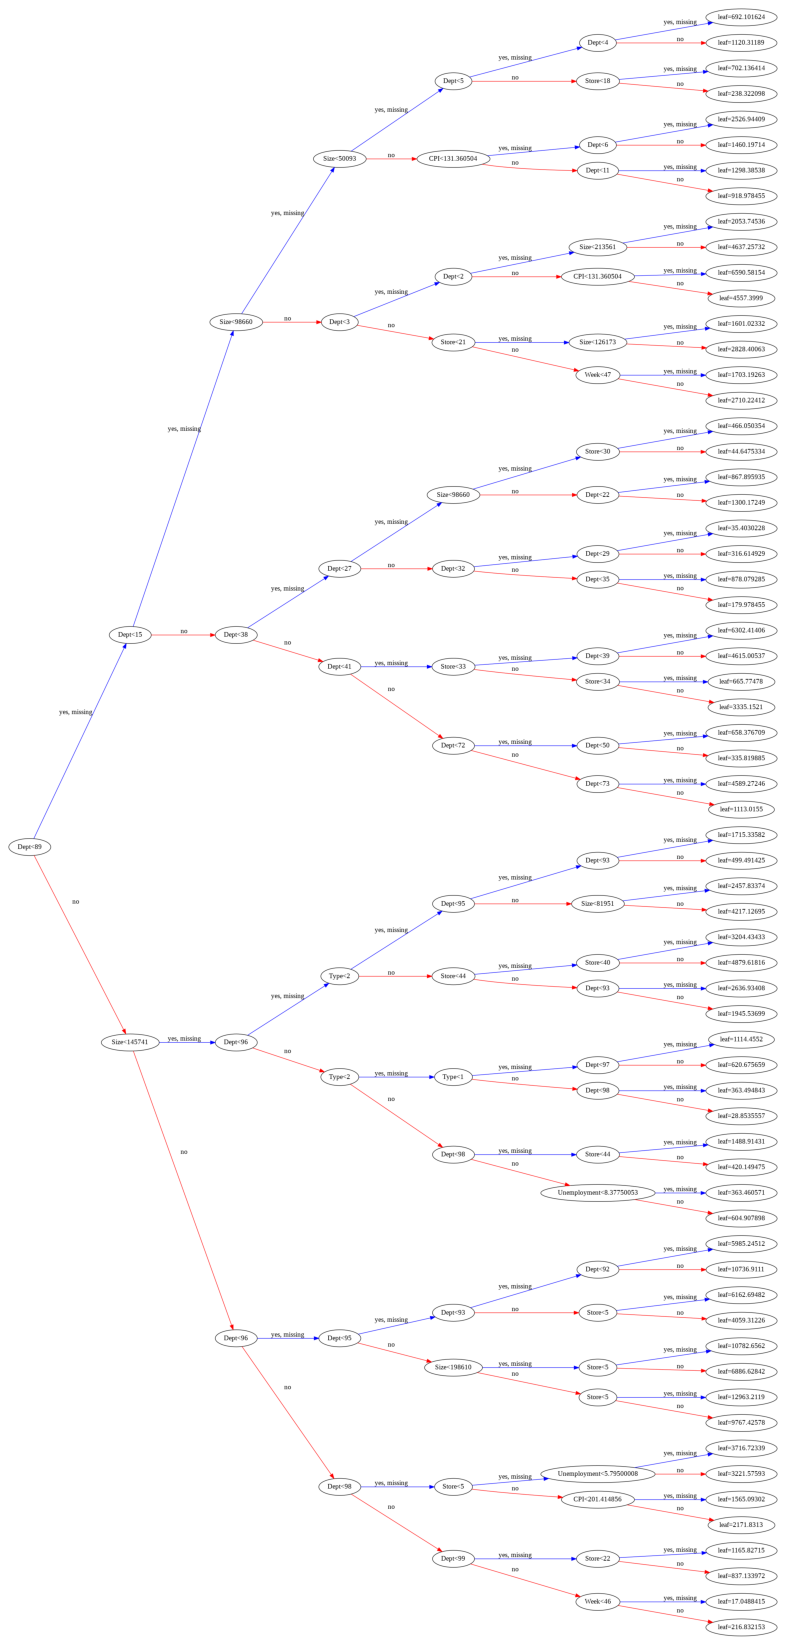

In [ ]:
# plot_tree(model, rankdir='LR', num_trees=1);

#### 모델을 예측값 생성

In [31]:
preds_train = model.predict(x_train)
preds_validation = model.predict(x_val)

#### train set에 대한 score와 rmse 확인
- squared=True : mse
- squared=False : rmse

In [34]:
score = model.score(x_train, y_train)  
print("Training score: ", score)
print("Root Mean Square Error: ", mean_squared_error(preds_train, y_train, squared=False))

Training score:  0.9391059714980045
Root Mean Square Error:  5588.174921273773


#### validation set에 대한 score와 rmse 확인

In [35]:
score = model.score(x_val, y_val)
print("Validation score: ", score)
print("Root Mean Square Error: ", mean_squared_error(preds_validation, y_val, squared=False))

Validation score:  0.9234015172769325
Root Mean Square Error:  6288.695186971017


#### test set의 전처리 및 예측값 생성

In [23]:
x_test = df_test.drop(['Date', 'Day_name', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','split','Weekly_Sales'], axis=1)

test_preds_sub1 = model.predict(x_test)

#### test.csv의 값에 대한 예측값을 그래프로 표현

C:\Users\popcorn\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date'>

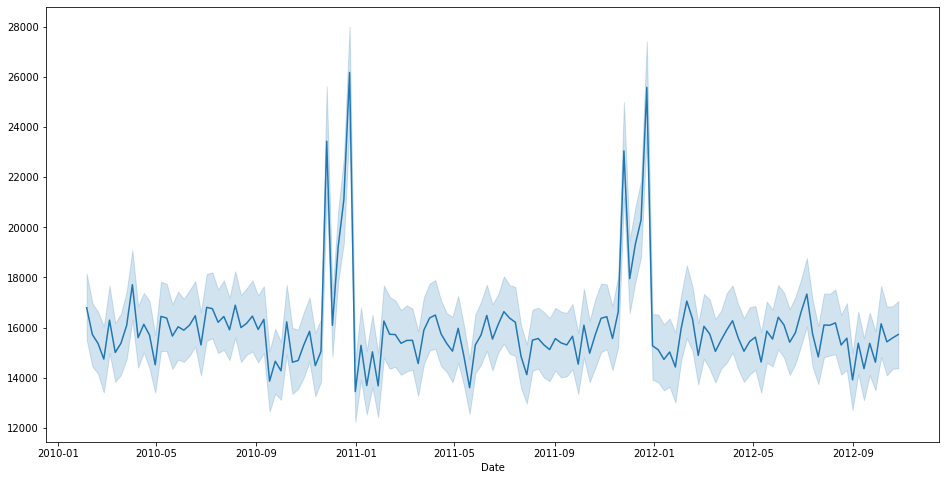

In [24]:
plt.figure(figsize=(16,8))
sns.lineplot(df_test['Date'], test_preds_sub1)